In [1]:
#импортируем нужные библиотеки и получаем данные из файла case1-1_data.csv
import numpy as np
import pandas as pd
df = pd.read_csv('case_1')

In [2]:
#получаем первые десять записей из файла
df.head(10)

,time,requests
0,2021-03-30 05:05:30,1
1,2021-03-24 03:05:00,188
2,2021-03-27 06:15:00,519
3,2021-03-26 17:44:30,2939
4,2021-03-30 13:15:30,3407
5,2021-03-30 05:46:30,86
6,2021-03-28 01:09:30,1753
7,2021-03-31 13:18:30,9
8,2021-03-27 04:27:00,248
9,2021-03-24 05:22:00,2


In [3]:
#узнаем размерность дата фрейма
df.shape

(124761, 2)

In [4]:
#получаем информацию о полях и узнаем есть ли пропущенные значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124761 entries, 0 to 124760
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   time      124761 non-null  object
 1   requests  124761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [5]:
#получаем информацию касательно самих данных(min max std meand etc.)
df.describe()

,requests
count,124761.000000
mean,1160.327971
std,1553.497319
min,1.000000
25%,20.000000
50%,106.000000
75%,2498.000000
max,7555.000000


Я не знаю, является ли число 7555 requests выбросом, или это нормальное значение. Буду выполнять работу считая, что это не выброс.

In [6]:
#узнаем количество уникальных значений для каждого из столбцов
df.nunique()

time        28798
requests     5786
dtype: int64

In [7]:
#узнаем количество для каждого из значений
feature_names = df.columns.tolist() 
for column in feature_names: 
    print (column) 
    print (df[column].value_counts(dropna=False))

time
2021-03-25 08:21:30    6
2021-03-27 20:42:00    6
2021-03-24 19:10:30    6
2021-03-29 19:17:00    6
2021-03-30 10:58:30    6
                      ..
2021-03-22 07:04:30    3
2021-03-22 04:57:30    3
2021-03-23 05:23:00    3
2021-03-22 00:14:30    3
2021-03-22 02:52:30    3
Name: time, Length: 28798, dtype: int64
requests
1       2500
3       2194
6       2137
7       1955
4       1936
        ... 
5891       1
6284       1
5034       1
5454       1
6427       1
Name: requests, Length: 5786, dtype: int64


У меня появился вопрос, если данные принадлежат одному пользователю, время одинаковое у шести разных строк и количество запросов на них разное. Как именно в этой ситуации строить прогностическую модель? Оставить все как есть или же на каждую дату сложить количество всех запросов? Пожалуй сложить запросы по одинаковой дате логичен выберу его.

In [8]:
#получаем уникальные значени в time
list_of_value = []
for i in df['time']:
    list_of_value.append(i)
list_unique = set(list_of_value)
len(list_unique)

28798

In [9]:
#при помощи данного кода мы суммируем кол-во запросов по каждой уникальной дате
df_sum_mat = [[]]
for i in list_unique:
    data = df.loc[df['time'] == i ]
    df_sum_mat.append([i , data['requests'].sum()])

In [10]:
# теперь преобразовываем полученные данные и выводим их сортирую по дате
df_sum_mat = df_sum_mat[1:]
a,b = [],[]
for i in range(len(df_sum_mat)):
    a.append(df_sum_mat[i][0])
    b.append(df_sum_mat[i][1])
data = pd.DataFrame({'time':a,'requests':b})
data.sort_values('time')

,time,requests
11909,2021-03-21 18:18:30,6301
21168,2021-03-21 18:19:00,6122
2186,2021-03-21 18:19:30,5899
27524,2021-03-21 18:20:00,5749
19006,2021-03-21 18:20:30,5068
...,...,...
22774,2021-03-31 18:16:00,6675
20718,2021-03-31 18:16:30,6434
186,2021-03-31 18:17:00,5666
14626,2021-03-31 18:17:30,6154


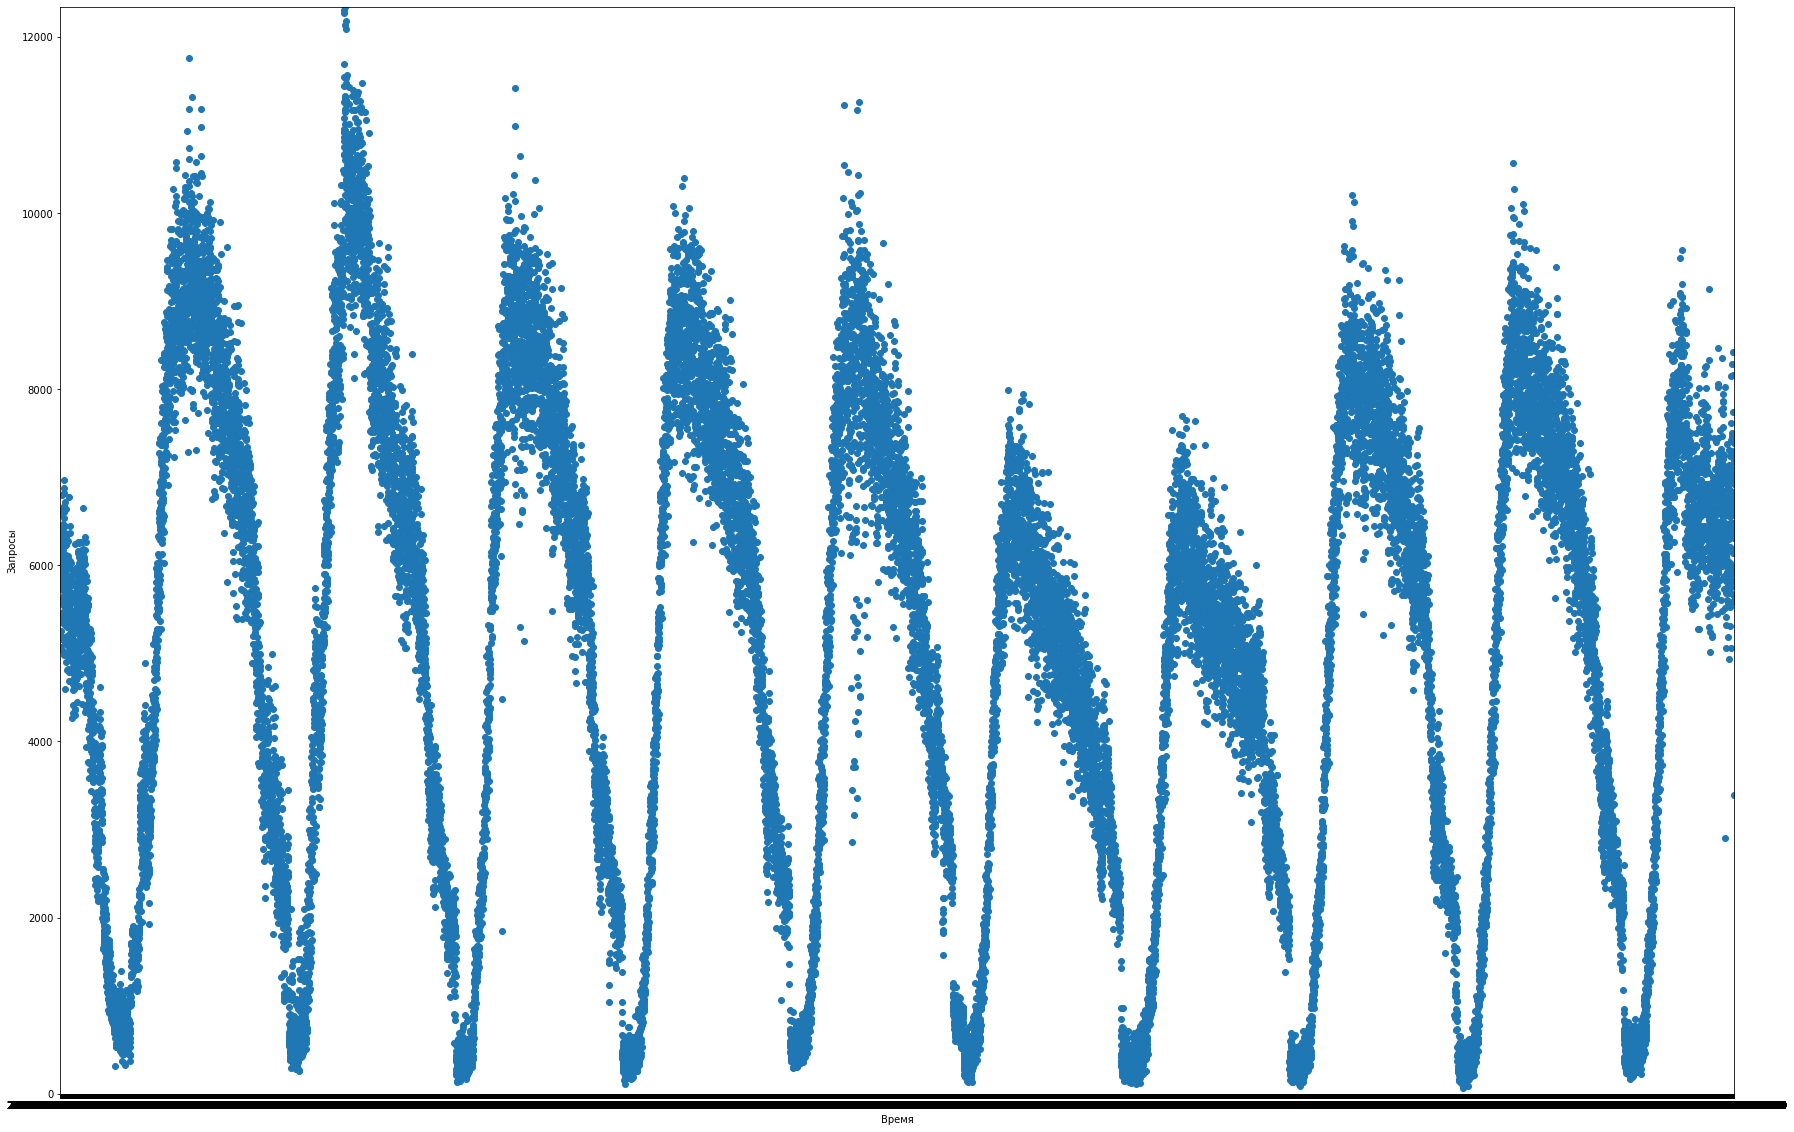

In [12]:
#отрисовываем получившиеся данные 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.scatter(data.sort_values('time')['time'],data.sort_values('time')['requests'])
plt.xlabel('Время')
plt.ylabel('Запросы')
plt.xlim(data['time'][11909],data['time'][7053])
plt.ylim(0, 12344)

plt.show()

In [13]:
#импортируем библиотеку Facebook для прогнозирования временных рядов Prophet.
from pandas import to_datetime
from fbprophet import Prophet

#prophet требует, чтобы колонки были с именами время-ds, target-y
data.columns = ['ds', 'y']

#преобразовываем поле ds в datetime
data['ds']= to_datetime(data['ds'])

#импортируем библиотеку, которая позволяет делить нашу выборку
#k-fold я использовал в черновиках но особой разницы нет
from sklearn.model_selection import train_test_split

#делим данные на тренировачные и тестовые в отношении 0.33
X_train, X_test, y_train, y_test = train_test_split(data['ds'], data['y'], test_size=0.33, random_state=42)

df_train = pd.DataFrame({'ds':X_train,'y':y_train})
df_test = pd.DataFrame({'ds':X_test,'y':y_test})

#создаем объект алгоритма
model = Prophet()

#тренируем модель
model.fit(df_train)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [14]:
#прогнозируем данные
model.predict(pd.DataFrame({'ds':X_test}))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-21 18:18:30,4313.322416,5073.835988,6709.763827,4313.322416,4313.322416,1560.601480,1560.601480,1560.601480,1560.601480,1560.601480,1560.601480,0.0,0.0,0.0,5873.923896
1,2021-03-21 18:20:00,4315.722936,5094.321572,6680.051215,4315.722936,4315.722936,1553.958846,1553.958846,1553.958846,1553.958846,1553.958846,1553.958846,0.0,0.0,0.0,5869.681783
2,2021-03-21 18:20:30,4316.523110,5082.690709,6692.034243,4316.523110,4316.523110,1551.746301,1551.746301,1551.746301,1551.746301,1551.746301,1551.746301,0.0,0.0,0.0,5868.269411
3,2021-03-21 18:21:00,4317.323283,5056.541934,6694.709236,4317.323283,4317.323283,1549.534545,1549.534545,1549.534545,1549.534545,1549.534545,1549.534545,0.0,0.0,0.0,5866.857828
4,2021-03-21 18:22:00,4318.923630,5039.046709,6663.378765,4318.923630,4318.923630,1545.113297,1545.113297,1545.113297,1545.113297,1545.113297,1545.113297,0.0,0.0,0.0,5864.036927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,2021-03-31 18:11:30,4649.293718,5393.258822,6961.537814,4649.293718,4649.293718,1591.716351,1591.716351,1591.716351,1591.716351,1591.716351,1591.716351,0.0,0.0,0.0,6241.010069
9500,2021-03-31 18:12:30,4649.068304,5411.382353,7035.103317,4649.068304,4649.068304,1587.258377,1587.258377,1587.258377,1587.258377,1587.258377,1587.258377,0.0,0.0,0.0,6236.326681
9501,2021-03-31 18:14:00,4648.730183,5470.539976,7017.673154,4648.730183,4648.730183,1580.579994,1580.579994,1580.579994,1580.579994,1580.579994,1580.579994,0.0,0.0,0.0,6229.310177
9502,2021-03-31 18:16:00,4648.279355,5457.220043,7012.451519,4648.279355,4648.279355,1571.690665,1571.690665,1571.690665,1571.690665,1571.690665,1571.690665,0.0,0.0,0.0,6219.970020


In [15]:
#импортируем нужные библиотеки для метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [18]:
print('MSE: ',mean_squared_error(df_test['y'], model.predict(pd.DataFrame({'ds':X_test}))['yhat']))

MSE:  14554083.014992328


In [19]:
print('MAE: ',mean_absolute_error(df_test['y'], model.predict(pd.DataFrame({'ds':X_test}))['yhat']))

MAE:  3097.721575926657


In [21]:
df_test.sort_values('ds')

,ds,y
11909,2021-03-21 18:18:30,6301
27524,2021-03-21 18:20:00,5749
19006,2021-03-21 18:20:30,5068
4475,2021-03-21 18:21:00,5188
28536,2021-03-21 18:22:00,6205
...,...,...
3483,2021-03-31 18:11:30,6353
9040,2021-03-31 18:12:30,6576
17990,2021-03-31 18:14:00,6953
22774,2021-03-31 18:16:00,6675


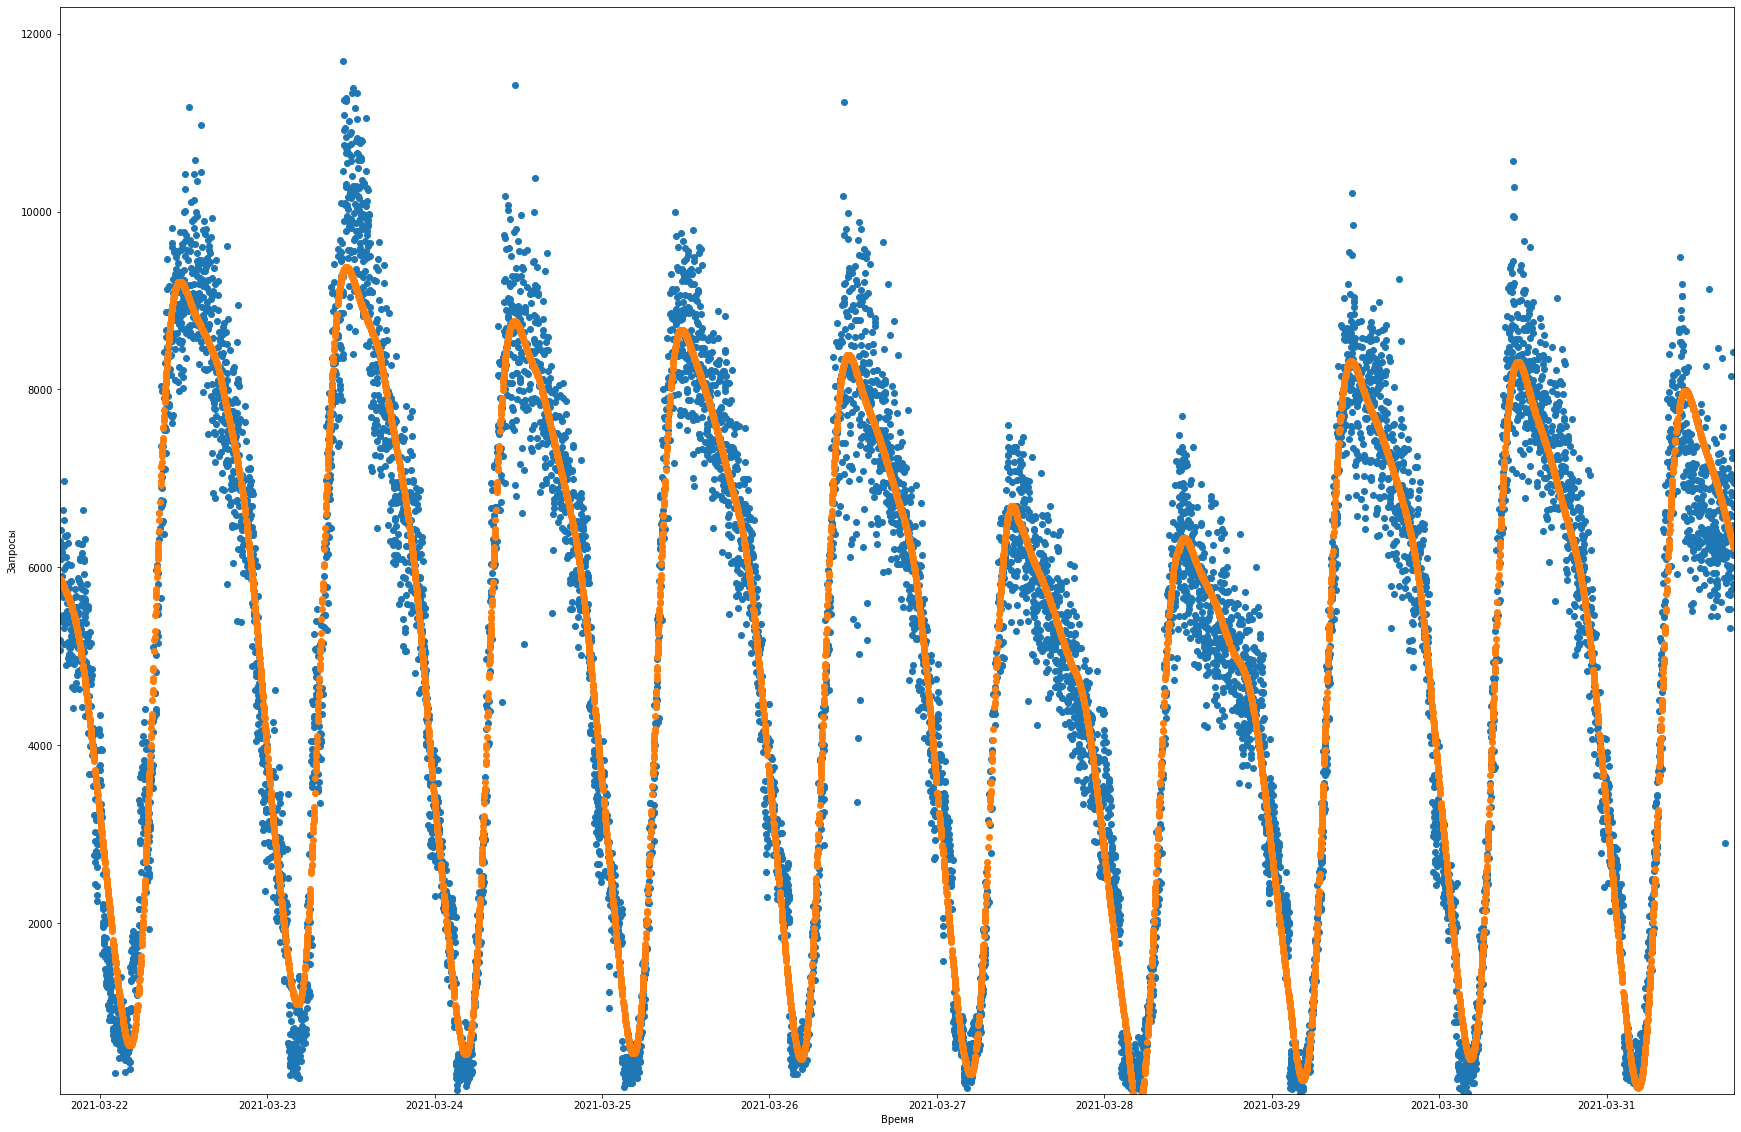

In [22]:
#Нарисуем реальные данные с прогнозированными вместе на одном графике
plt.figure(figsize=(30,20))
plt.scatter(df_test.sort_values('ds')['ds'],df_test.sort_values('ds')['y'])
plt.scatter(df_test.sort_values('ds')['ds'], model.predict(pd.DataFrame({'ds':X_test}))['yhat'])
plt.xlabel('Время')
plt.ylabel('Запросы')
plt.xlim(df_test.sort_values('ds')['ds'][11909],df_test.sort_values('ds')['ds'][20718])
plt.ylim(83, 12304)

plt.show()

In [23]:
#прогнозируем кол-во запросов после минуты взяв крайнюю дату из предоставленных данных 2021-03-31 18:18:00
future_minute_str = '2021-03-31 18:19:00'
future_minute = to_datetime(future_minute_str)
f_m = pd.DataFrame({'ds':[future_minute]})
print('Прогноз через минуту: ',model.predict(f_m)['yhat'][0])

Прогноз через минуту:  6205.9895238212775


In [24]:
#прогнозируем кол-во запросов после часа взяв крайнюю дату из предоставленных данных 2021-03-31 18:18:00
future_hour_str = '2021-03-31 19:18:00'
future_hour = to_datetime(future_hour_str)
f_h = pd.DataFrame({'ds':[future_hour]})
print('Прогноз через минуту: ',model.predict(f_h)['yhat'][0])

Прогноз через минуту:  5927.200418158772


In [25]:
#прогнозируем кол-во запросов после одного дня взяв крайнюю дату из предоставленных данных 2021-03-31 18:18:00
future_day_str = '2021-04-01 18:18:00'
future_day = to_datetime(future_day_str)
f_d = pd.DataFrame({'ds':[future_day]})
print('Прогноз через день: ',model.predict(f_d)['yhat'][0])

Прогноз через день:  5886.049947158877


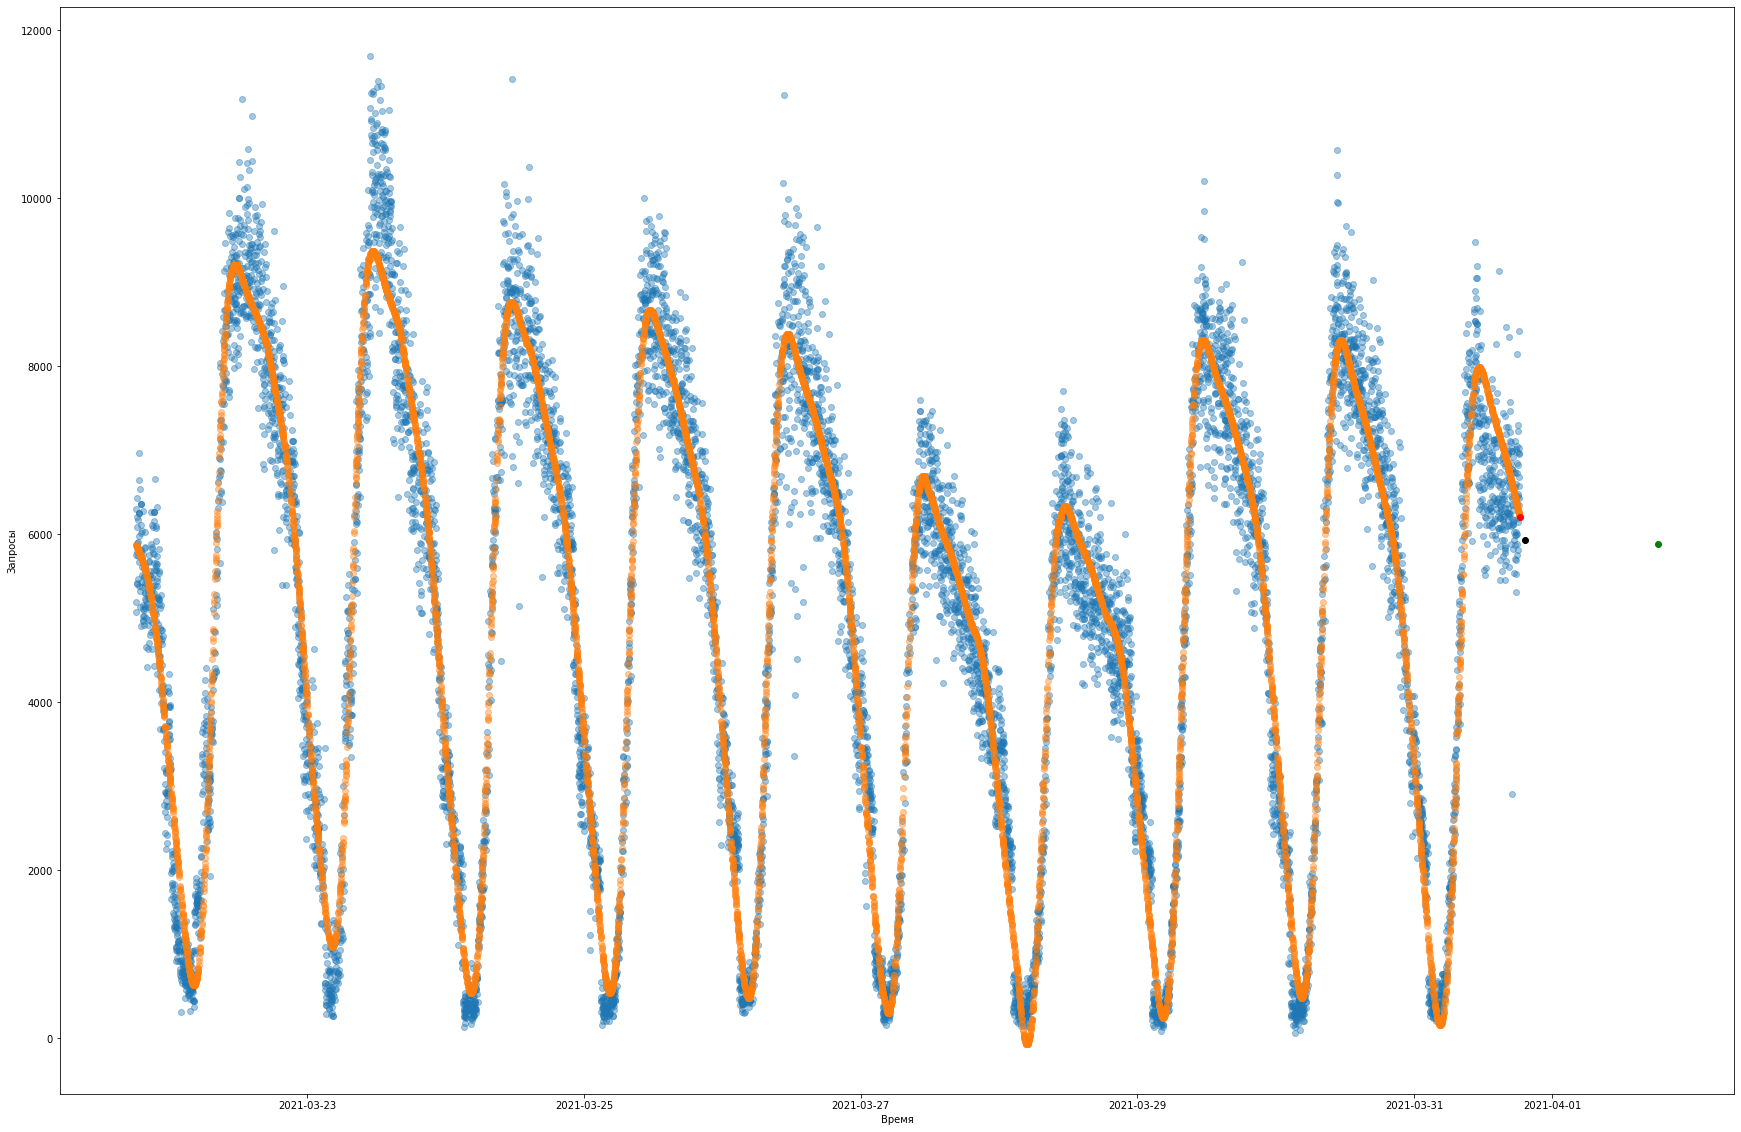

In [27]:
# отрисовываем график уже с прогнозированными данными
plt.figure(figsize=(30,20))
plt.scatter(df_test.sort_values('ds')['ds'],df_test.sort_values('ds')['y'],alpha=0.4)
plt.scatter(df_test.sort_values('ds')['ds'], model.predict(df_test)['yhat'],alpha=0.4)
#красная точка на графике отвечает за предикт через минуту
plt.scatter(f_m, model.predict(f_m)['yhat'][0],c=['red'],alpha=1)
#черная точка на графике отвечает за предикт через час
plt.scatter(f_h, model.predict(f_h)['yhat'][0],c=['black'],alpha=1)
#зеленая точка на графике отвечает за предикт через день
plt.scatter(f_d, model.predict(f_d)['yhat'][0],c=['green'],alpha=1)
plt.xlabel('Время')
plt.ylabel('Запросы')
# plt.xlim(df_test.sort_values('ds')['ds'][10727],df_test.sort_values('ds')['ds'][18245])
# plt.ylim(83, 12304)

plt.show()